In [0]:
! git clone https://github.com/ANN-2019-2/evaluacion-deescobarc.git

Cloning into 'evaluacion-deescobarc'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 50 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.


#Librerías a Utilizar

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

from nltk.stem.porter import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import tensorflow as tf
from tensorflow import keras



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


#Pruebas GPU

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

#Leer los datos

In [4]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/sms-spam.csv",
    sep = ',',
    thousands = None,
    decimal = '.',
    encoding='latin-1')

df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


##Verificación de la lectura

In [5]:
##
## Verifica la lectura de los datos
##
df.describe()

,type,text
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


#Cantidad de mensajes por tipo

In [6]:
##
## Se obtiene la cantidad de casos para
## cada tipo de mensaje.
##
df.type.value_counts()

ham     4827
spam     747
Name: type, dtype: int64

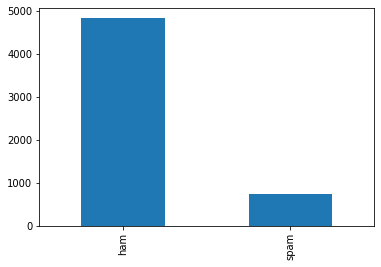

In [7]:
df.type.value_counts().plot.bar();

#Stemmer

In [9]:
stemmer = PorterStemmer()

df['stemmed'] = df.text.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))

df.head(10)

,type,text,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darl it' been 3 week' now an...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,As per your request 'mell mell (oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner!! As a valu network custom you have bee...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobil 11 month or more? U R entitl to...


#Matriz de Términos del Documento (Bag of words)

In [11]:
##
## Matriz de términos del documento en Python
##
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5                # ignora palabras con baja freq
)


##
## Aplica la función al texto
##
dtm = count_vect.fit_transform(df.stemmed)

##
## Las filas contienen los mensajes
## y las clomunas los términos
##
dtm.shape

(5574, 1540)

In [12]:
##
## Palabras aprendidas de los mensajes de texto
##
vocabulary = count_vect.get_feature_names()
len(vocabulary)

1540

In [13]:
##
## Primeras palabras del vocabulario
##
vocabulary[0:10]

['00',
 '000',
 '02',
 '03',
 '04',
 '06',
 '0800',
 '08000839402',
 '08000930705',
 '0870']

In [14]:
##
## Recupera los mensajes de la dtm
##
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index,:].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs

for i, x in enumerate(dtm2words(dtm, vocabulary, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])):
    print('Org: ', df.text[i])
    print('Mod: ', ' '.join(x))
    print('')

Org:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Mod:  avail bugi cine got great la onli point wat world

Org:  Ok lar... Joking wif u oni...
Mod:  joke lar ok wif

Org:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Mod:  appli comp cup entri final free question rate receiv std text txt win wkli

Org:  U dun say so early hor... U c already then say...
Mod:  alreadi dun earli say

Org:  Nah I don't think he goes to usf, he lives around here though
Mod:  don goe live nah think usf

Org:  FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
Mod:  50 darl freemsg fun hey like ok send std week word xxx

Org:  Even my brother is not like to speak with me. They treat me like aids patent.
Mod:  brother like speak treat

Or

#Se separan los datos de entrenamiento y prueba

In [0]:
##
## Creación de los conjuntos de entrenamiento y prueba.
##
X_train      = dtm[0:4168,]
X_test       = dtm[4169:,]
y_train_true = df.type[0:4168]
y_test_true  = df.type[4169:]

#Regresión logística

In [0]:
logisticRegression = LogisticRegression(
    penalty='l2',            # ‘l1’, ‘l2’, ‘elasticnet’, ‘none’
    tol=0.0001,              # stop criteria
    C=1.0,                   # factor inverso para regularizacion (SVM)
    fit_intercept=True,      #
    class_weight=None,       # None, dict or ‘balanced’
    random_state=None,       #
    solver='lbfgs',          # 'newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
    max_iter=100,            #
    multi_class='auto',      # ‘ovr’, ‘multinomial’, ‘auto’
    verbose=0,               #
    warm_start=False,        # ?re-usa la solución previa
    l1_ratio=None            # Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1
)

##Se realiza el entrenamiento y la evaluación

In [0]:
lr = logisticRegression.fit(X_train, y_train_true)
y_pred = logisticRegression.predict(X_test)

##Se valida la matriz de confusión

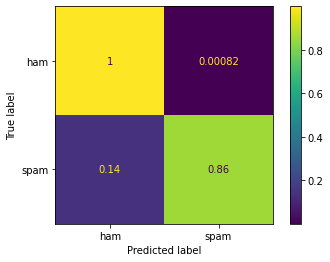

In [33]:
confusion_matrix(y_test_true, y_pred)
plot_confusion_matrix(lr,X_test,y_test_true,normalize='true');

El módelo de regresión logística detecta correos ham con una alta probabilidad pero en spam no se obtienen los mismos resultados

##Robustez del modelo

In [43]:
res = cross_val_score(lr, X_test, y_test_true)
print("Promedio: ",res.mean())

Promedio:  0.9637010676156583


#Red Neuronal

Primero se busca el número de capas adecuado

In [60]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(
            hidden_layer_sizes=(5,5),
            activation='logistic',
            solver='sgd',
            learning_rate='adaptive',
            learning_rate_init=0.05,
            random_state=123,
            max_iter=1000
        )

model.fit(X_train,y_train_true)
forecast_y = model.predict(X_test)

Epoch 1/30


ValueError: ignored